## Project: From Model to Production  

Anomaly Detection Model to Production

In [1]:
import numpy as np
import pandas as pd
from pubnub.pubnub import PubNub
from pubnub.pnconfiguration import PNConfiguration
from pubnub.callbacks import SubscribeCallback
import csv
from datetime import datetime
import os
from sklearn.ensemble import IsolationForest
import joblib
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## Collect the dataset using the PubNub

In [4]:
pnconfig = PNConfiguration()
pnconfig.subscribe_key = 'sub-c-99084bc5-1844-4e1c-82ca-a01b18166ca8'
pnconfig.uuid = 'MyIdentifier'

pubnub = PubNub(pnconfig)
channel = 'pubnub-sensor-network'

# File setup
filename = 'sensor_data.csv'
header = ['timestamp', 'temperature', 'humidity', 'sound_volume']

if not os.path.exists(filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

# Listener
class MySubscribeCallback(SubscribeCallback):
    def message(self, pubnub, message):
        data = message.message
        try:
            row = [
                datetime.utcnow().isoformat(),
                data['ambient_temperature'], 
                data['humidity'],
                data['photosensor']  # mapped to sound_volume
           ]

            with open(filename, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(row)

            print("Logged:", row)

        except KeyError as e:
            print("Missing expected key:", e)
            print("Received data:", data)

pubnub.add_listener(MySubscribeCallback())
pubnub.subscribe().channels(channel).execute()

Logged: ['2025-06-15T16:41:20.001008', 21.11, 79.8545, 776.86]
Logged: ['2025-06-15T16:41:20.207974', 20.87, 80.3118, 775.11]
Logged: ['2025-06-15T16:41:20.403139', 21.01, 80.302, 788.91]
Logged: ['2025-06-15T16:41:20.608255', 20.82, 79.8689, 754.55]
Logged: ['2025-06-15T16:41:20.804966', 21, 80.2746, 813.59]
Logged: ['2025-06-15T16:41:21.003043', 20.96, 80.549, 815.18]
Logged: ['2025-06-15T16:41:21.203965', 21.02, 80.4847, 811.19]
Logged: ['2025-06-15T16:41:21.415172', 20.99, 80.4876, 806.78]
Logged: ['2025-06-15T16:41:21.613722', 21.03, 80.0702, 779.22]
Logged: ['2025-06-15T16:41:21.805203', 20.92, 80.3143, 755.07]
Logged: ['2025-06-15T16:41:22.013492', 21.23, 79.9573, 795.97]
Logged: ['2025-06-15T16:41:22.216891', 20.95, 80.644, 766.93]
Logged: ['2025-06-15T16:41:22.412065', 20.97, 80.2444, 829.91]
Logged: ['2025-06-15T16:41:22.606231', 20.99, 79.9507, 854.85]
Logged: ['2025-06-15T16:41:22.812278', 21.08, 79.2356, 816.01]
Logged: ['2025-06-15T16:41:23.007788', 21.09, 79.4013, 816.47

## Train an Anomaly Detection Model

In [2]:
# Load data
df = pd.read_csv("sensor_data.csv")

# Select features
X = df[['temperature', 'humidity', 'sound_volume']]

# Train the model
model = IsolationForest(n_estimators=420, contamination=0.02, random_state=42)
model.fit(X)

# Predict
df['anomaly'] = model.predict(X)
df['score'] = model.decision_function(X)

# Save model
joblib.dump(model, "anomaly_model.pkl")

# View summary
print(df['anomaly'].value_counts())
print(df.tail())

anomaly
 1    3402
-1      69
Name: count, dtype: int64
                       timestamp  temperature  humidity  sound_volume  \
3466  2025-06-15T16:44:56.042505        21.04   80.0710        818.02   
3467  2025-06-15T16:44:56.045253        21.04   80.0710        818.02   
3468  2025-06-15T16:44:56.246564        21.18   81.1301        807.04   
3469  2025-06-15T16:44:56.248564        21.18   81.1301        807.04   
3470  2025-06-15T16:44:56.445011        21.01   80.2792        843.66   

      anomaly     score  
3466        1  0.193098  
3467        1  0.193098  
3468       -1 -0.019536  
3469       -1 -0.019536  
3470        1  0.149000  


In [3]:
score = silhouette_score(df[['temperature', 'humidity', 'sound_volume']], df['anomaly'])
print("Silhouette Score:", score)

Silhouette Score: 0.41478185670887757


Isolation Forest selected as anomaly detection model for deployment. It achieved a silhouette score of 0.41and produced a controlled anomaly rate (approx 2%) while maintaining efficient, real-time performance.

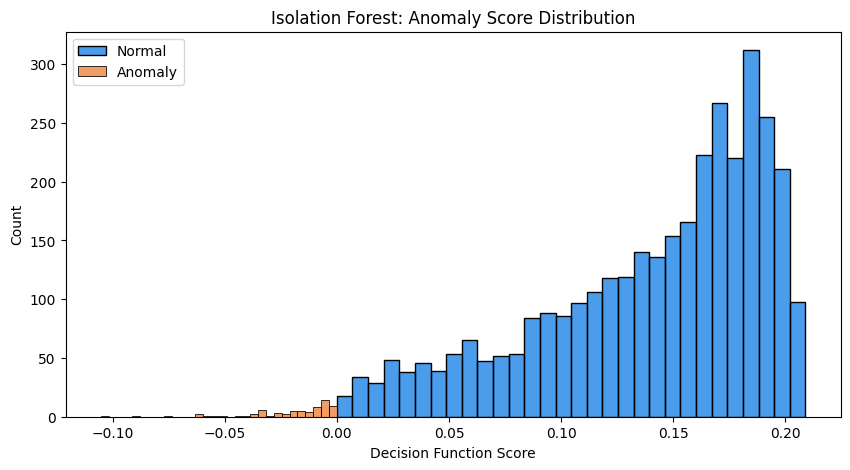

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df['anomaly'] == 1]['score'], bins=30, color='#107be6', label='Normal')
sns.histplot(df[df['anomaly'] == -1]['score'], bins=30, color='#ed7d31', label='Anomaly')
plt.title("Isolation Forest: Anomaly Score Distribution")
plt.xlabel("Decision Function Score")
plt.ylabel("Count")
plt.legend()

filename = "anomaly_score_distribution.jpg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')
plt.show()